In [1]:
# python lib
import os
import shutil
import sys
import subprocess
import time
original_directory = os.getcwd()
# import alolib
import copy

# local import
os.chdir(os.path.abspath(os.path.join('..')))
from common import Logger, print_color, find_matching_strings, asset_info, extract_requirements_txt, check_install_requirements

In [2]:
req_list = extract_requirements_txt("master")
master_req = {"master": req_list}

check_install_requirements(master_req)

======================================== Start dependency installation - step : << master >> ========================================
>> Start checking existence & installing package - alolib@git+http://mod.lge.com/hub/dxadvtech/aicontents-framework/alolib-source.git | Progress: ( 1 / 1 total packages )
- << alolib@git+http://mod.lge.com/hub/dxadvtech/aicontents-framework/alolib-source.git >> already exists
======================================== Finish dependency installation ======================================== 



In [3]:
from alolib.asset import Asset
from alolib.exception import print_color

In [4]:
# !make clean

In [5]:
# !make del

In [6]:
os.chdir(os.path.abspath(os.path.join(original_directory)))

In [7]:
# 현재 위치 확인

PROJECT_HOME = os.path.dirname(os.getcwd())
# experimental plan yaml의 위치
EXP_PLAN = PROJECT_HOME + "/config/experimental_plan.yaml"
# asset 코드들의 위치
SCRIPT_HOME = PROJECT_HOME + "/assets/"

envs = {}
envs['project_home'] = PROJECT_HOME + "/"

SUPPORT_TYPE = ['memory', 'file']

In [8]:
req_list = extract_requirements_txt("master")
master_req = {"master": req_list}
check_install_requirements(master_req)

======================================== Start dependency installation - step : << master >> ========================================
>> Start checking existence & installing package - alolib@git+http://mod.lge.com/hub/dxadvtech/aicontents-framework/alolib-source.git | Progress: ( 1 / 1 total packages )
- << alolib@git+http://mod.lge.com/hub/dxadvtech/aicontents-framework/alolib-source.git >> already exists
======================================== Finish dependency installation ======================================== 



In [9]:
# asset init
asset = Asset(envs=envs, argv=0, version=0.1)

In [10]:
# configure setting
asset.get_yaml(EXP_PLAN)
external_path = asset.get_external_path()
external_path_permission = asset.get_external_path_permission()
pipelines_list = asset.get_pipeline()
user_parameters = asset.get_user_parameters()
controls = asset.get_control()
artifacts = asset.set_artifacts()

In [11]:
# 외부 데이터 다운로드 (input 폴더에)
asset.fetch_data(external_path, external_path_permission)

>> Start removing pre-existing input data before fetching external data: <DirEntry 'inf'>
>> Start removing pre-existing input data before fetching external data: <DirEntry 'train_missing'>
>> s3 private key file << load_s3_key_path >> loaded successfully.
>> Start fetching external data from << /nas001/users/yoonji.suh/tcr_test_20231011/train_missing/ >> into << input >> folder.
>> Start fetching external data from << /nas001/users/yoonji.suh/tcr_test_20231011/inf/ >> into << input >> folder.


In [12]:
pipe_mode = 'train_pipeline'

In [13]:
####################### ALO master requirements 리스트업 #######################
# ALO master requirements 는 최우선 순위로 설치 > 만약 ALO master requirements는 aiplib v2.1인데 slave 제작자가 aiplib v2.2로 명시해놨으면 2.1이 우선 
requirements_dict = dict() 
requirements_dict['master'] =  extract_requirements_txt(step_name = 'master')
####################### Slave Asset 설치 및 Slave requirements 리스트업 #######################

# setup asset (asset을 git clone (or local) 및 requirements 설치)
get_asset_source = controls["get_asset_source"]  # once, every
for step, asset_config in enumerate(pipelines_list[pipe_mode]):
    # self.asset.setup_asset 기능 :
    # local or git pull 결정 및 scripts 폴더 내에 위치시킴 
    asset.setup_asset(asset_config, get_asset_source)
    requirements_dict[asset_config['step']] = asset_config['source']['requirements']
    # local 모드일 땐 이번 step(=asset)의 종속 package들이 내 환경에 깔려있는 지 항상 체크 후 없으면 설치 
    # git 모드일 땐 every이거나 once면서 첫 실행 시에만 requirements 설치 

####################### Master & Slave requirements 설치 #######################
# 이미 asset (step) 폴더들은 input 폴더에 다 setup된 상태 
# 각 asset의 yaml에 직접 작성 된 패키지들 + asset 내의 requirements.txt를 참고하여 쭉 리스트업 
# asset 간 중복 패키지 존재 시 먼저 실행되는 pipeline, asset에 대해 우선순위 부여하여 설치되게끔   
# 패키지 설치 중에 진행중인 asset 단계 표시 및 총 설치 중 몇번 째 설치인지 표시 > pipeline 별로는 별도로 진행 
asset.check_install_requirements(requirements_dict) 

input asset has already been created at 2023-10-13 01:17:57.236890
preprocess asset has already been created at 2023-10-13 01:17:58.318897
sampling asset has already been created at 2023-10-13 01:17:59.833907
train asset has already been created at 2023-10-13 01:30:36.892990
Ignored installing << pandas>=1.5.3 >>. Another version will be installed in the previous step.
Ignored installing << pandas==1.5.3 >>. Another version will be installed in the previous step.
Ignored installing << pandas==1.5.3 >>. Another version will be installed in the previous step.
Ignored installing << numpy==1.25.2 >>. Another version will be installed in the previous step.
Ignored installing << scikit-learn >>. Another version will be installed in the previous step.
======================================== Start dependency installation - step : << master >> ========================================
>> Start checking existence & installing package - alolib@git+http://mod.lge.com/hub/dxadvtech/aicontents-frame

In [14]:
check_asset_source = controls["get_asset_source"]

In [15]:
def run(step, args, pipelines, data, pipe_val):
    asset_config = pipelines_list[pipelines][step]
    asset.setup_asset(asset_config, check_asset_source)
    
    asset_info(pipelines, asset_config['step'])
    
    # scripts 폴더에 있는 내용을 가져와 import 한다
    _path = SCRIPT_HOME + asset_config['step'] + "/"
    _file = "asset_" + asset_config['step']
    user_asset = asset.import_asset(_path, _file)
    
    if controls['interface_mode'] in SUPPORT_TYPE:
        # 첫 동작시에는 초기화하여 사용 
        if step == 0:
            data = 0
            pipe_val = {}
        else:
            if controls['interface_mode'] == 'memory':
                pass
            elif controls['interface_mode'] == 'file':
                data, pipe_val = asset.get_toss(pipelines, envs) # file interface
    else:
        return ValueError("only file and memory")
    
    envs = {}
    envs['project_home'] = PROJECT_HOME
    envs['pipeline'] = pipelines
    envs['step'] = user_parameters[pipelines][step]['step']
    envs['artifacts'] = artifacts
    
    ua = user_asset(envs, args, data, pipe_val)
    data, pipe_val = ua.run()
    
    # self.asset.save_file(data)

    sys.path = [item for item in sys.path if envs['step'] not in item]

    if controls['interface_mode'] == 'file':
        asset.toss(data, pipe_val, pipelines, envs)
    else:
        return data, pipe_val

In [16]:
data = 0
pipe_val = 0

## Train workflow: 1. Input assets

In [17]:
pipelines = 'train_pipeline'; step = 0
args = user_parameters[pipelines][step]['args'][0]
if controls['interface_mode'] == 'file':
    run(step, pipelines, data, pipe_val)
else:
    data, config = run(step, args, pipelines, data, pipe_val)
data

input asset has already been created at 2023-10-13 01:17:57.236890



============================= ASSET INFO =============================
PIPELINES    : train_pipeline
ASSETS       : input



==================== current time : 2023-10-13 07:43:49.503091+00:00 (UTC) ====================
************************************************************
************************************************************
>> Load path : ['/home/jovyan/project/ALO_v2/alov2/input/train_missing/']
>> The file for batch data has been loaded. (File name: /home/jovyan/project/ALO_v2/alov2/input/train_missing/BF_stat.csv)
==================== Success loading dataframe ====================
>> Drop columns from the input dataframe when set << auto >> mode or specified in the << drop_columns >> in config yaml. (dropped colums:[])


{'dataframe':      Unnamed: 0   No      Time  Ch1  Ch2  Count  Fastening Time  \
 0             0  1.0  16:08:35    1    4    NaN            3207   
 1             1  1.0  16:08:11    1    4  661.0            3298   
 2             2  1.0  16:09:21    1    4    NaN            3469   
 3             3  1.0  16:09:43    1    4  644.0            3214   
 4             4  NaN  10:03:30    1    4  518.0            2586   
 ..          ...  ...       ...  ...  ...    ...             ...   
 495         496  1.0  11:50:49    1    4  480.0            2396   
 496         497  1.0  21:19:06    1    4  495.0            2472   
 497         498  1.0  18:59:56    1    4  517.0            2578   
 498         499  1.0  16:31:59    1    4  519.0            2587   
 499         500  1.0  15:27:55    1    4  492.0            2453   
 
      Target Torque  Converted Torque  Speed  ...  angle_median    angle_std  \
 0              6.0              6.02    250  ...        3469.0  1793.955856   
 1       

In [18]:
# read data from file
# get_toss(pipelines, envs)
# pipelines: 현재 동작중인 파이프라인 이름
# 현재 동작중인 환경 설정
if controls['interface_mode'] == 'file':
    step = 0
    # step: 현재 동작중인 asset number
    def make_envs(step):
        envs = {}
        envs['pipeline'] = pipelines
        envs['step'] = user_parameters[pipelines][step]['step']
        envs['artifacts'] = artifacts
        return envs
    data, pipe_val = asset.get_toss(pipelines, make_envs(step))

## Train workflow: 2. Preprocess assets

In [20]:
# 확인을 위한 input 데이터 백업
input_data = copy.copy(data)
input_config = copy.copy(config)

In [19]:
pipelines = 'train_pipeline'; step = 1
args = user_parameters[pipelines][step]['args'][0]

data, config = run(step, args, pipelines, data, config)
data

preprocess asset has already been created at 2023-10-13 01:17:58.318897



============================= ASSET INFO =============================
PIPELINES    : train_pipeline
ASSETS       : preprocess



Got model path for saving or loading: 
 /home/jovyan/project/ALO_v2/alov2/.train_artifacts/models/preprocess/
************************************************************
************************************************************
label column : label Encoder saved : /home/jovyan/project/ALO_v2/alov2/.asset_interface/
['Count_nan', 'Converted Torque_nan', 'angle_min_nan', 'angle_mean_nan', 'angle_median_nan', 'angle_std_nan', 'angle_max_nan', 'torque_min_nan', 'torque_mean_nan', 'torque_median_nan', 'torque_std_nan', 'torque_max_nan'] label_encoded_nan


fatal: No names found, cannot describe anything.


{'dataframe':      Count  Converted Torque  angle_min   angle_mean  angle_median  \
 0      NaN              6.02        0.0  3131.920561        3469.0   
 1    661.0              6.02        0.0  3206.416036        3572.0   
 2      NaN              6.02        0.0  3351.405755        3731.0   
 3    644.0              6.08        0.0  3138.203416        3475.0   
 4    518.0              6.04        0.0  2595.905405        2737.0   
 ..     ...               ...        ...          ...           ...   
 495  480.0              6.06        0.0  2369.070833        2442.0   
 496  495.0              6.06        0.0  2437.254545        2529.0   
 497  517.0              6.04        0.0  2538.899420        2657.0   
 498  519.0              6.05        0.0  2549.233141        2669.0   
 499  492.0              6.04        0.0  2421.243902        2507.0   
 
        angle_std  angle_max  torque_min  torque_mean  torque_median  ...  \
 0    1793.955856     5541.0        0.00     1.443754   

### 2-1. argument 수정해보기(결손치 처리 방식을 interpolation에서 dropna로 변경)

In [20]:
# input asset data와 config 다시 불러오기
data = copy.copy(input_data)
config = copy.copy(input_config)

In [21]:
pipelines = 'train_pipeline'; step = 1
args = user_parameters[pipelines][step]['args'][0]
args['handling_missing'] = 'dropna'
data, config = run(step, args, pipelines, data, config)
data

preprocess asset has already been created at 2023-10-13 01:17:58.318897



============================= ASSET INFO =============================
PIPELINES    : train_pipeline
ASSETS       : preprocess



Got model path for saving or loading: 
 /home/jovyan/project/ALO_v2/alov2/.train_artifacts/models/preprocess/
************************************************************
************************************************************
label column : label Encoder saved : /home/jovyan/project/ALO_v2/alov2/.asset_interface/
['Count_nan', 'Converted Torque_nan', 'angle_min_nan', 'angle_mean_nan', 'angle_median_nan', 'angle_std_nan', 'angle_max_nan', 'torque_min_nan', 'torque_mean_nan', 'torque_median_nan', 'torque_std_nan', 'torque_max_nan'] label_encoded_nan


fatal: No names found, cannot describe anything.


{'dataframe':      Count  Converted Torque  angle_min   angle_mean  angle_median  \
 1    661.0              6.02        0.0  3206.416036        3572.0   
 3    644.0              6.08        0.0  3138.203416        3475.0   
 4    518.0              6.04        0.0  2595.905405        2737.0   
 5    513.0              6.00        0.0  2570.904483        2702.0   
 6    499.0              6.02        0.0  2511.917836        2626.0   
 ..     ...               ...        ...          ...           ...   
 495  480.0              6.06        0.0  2369.070833        2442.0   
 496  495.0              6.06        0.0  2437.254545        2529.0   
 497  517.0              6.04        0.0  2538.899420        2657.0   
 498  519.0              6.05        0.0  2549.233141        2669.0   
 499  492.0              6.04        0.0  2421.243902        2507.0   
 
        angle_std  angle_max  torque_min  torque_mean  torque_median  ...  \
 1    1828.091133     5663.0       -0.10     1.540484   

## Train workflow: 2. Sampling assets

In [25]:
pipelines = 'train_pipeline'; step = 2
args = user_parameters[pipelines][step]['args'][0]

data, config = run(step, args, pipelines, data, config)
data

sampling asset has already been created at 2023-10-13 01:17:59.833907



============================= ASSET INFO =============================
PIPELINES    : train_pipeline
ASSETS       : sampling





/home/jovyan/conda/envs/alov22/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


************************************************************
************************************************************


/home/jovyan/project/ALO_v2/alov2/assets/sampling/asset_sampling.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sampled'].loc[sampled_idx] = 1 # 'sampled' == 1일 때 sampling 된 것


{'dataframe':      Count  Converted Torque  angle_min   angle_mean  angle_median  \
 0    661.0              6.02        0.0  3206.416036        3572.0   
 2    518.0              6.04        0.0  2595.905405        2737.0   
 4    499.0              6.02        0.0  2511.917836        2626.0   
 5    487.0              6.00        0.0  2446.459959        2545.0   
 6    505.0              6.02        0.0  2529.869307        2651.0   
 ..     ...               ...        ...          ...           ...   
 493  480.0              6.06        0.0  2369.070833        2442.0   
 494  495.0              6.06        0.0  2437.254545        2529.0   
 495  517.0              6.04        0.0  2538.899420        2657.0   
 496  519.0              6.05        0.0  2549.233141        2669.0   
 497  492.0              6.04        0.0  2421.243902        2507.0   
 
        angle_std  angle_max  torque_min  torque_mean  torque_median  ...  \
 0    1828.091133     5663.0       -0.10     1.540484   

## Train workflow: 2. TCR assets

train asset has already been created at 2023-10-13 01:30:36.892990



============================= ASSET INFO =============================
PIPELINES    : train_pipeline
ASSETS       : train



************************************************************
************************************************************
Got model path for saving or loading: 
 /home/jovyan/project/ALO_v2/alov2/.train_artifacts/models/train/
Got output path for saving or loading: 
 /home/jovyan/project/ALO_v2/alov2/.train_artifacts/output/train/
해당 column 은 Training 과정에 사용되지 않습니다. (column_name: ['torque_mean', 'angle_min', 'angle_mean', 'torque_min', 'Count', 'angle_median', 'angle_max', 'label', 'torque_median', 'torque_std', 'label_encoded_nan', 'Converted Torque', 'label_encoded', 'torque_max', 'angle_std'])
[INFO] 모델 학습을 시작합니다.



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[INFO] 0th-fold RandomForestClassifier_set0 모델을 학습합니다.(1/48)
[INFO] 1th-fold RandomForestClassifier_set0 모델을 학습합니다.(2/48)
[INFO] 2th-fold RandomForestClassifier_set0 모델을 학습합니다.(3/48)
[INFO] 3th-fold RandomForestClassifier_set0 모델을 학습합니다.(4/48)
[INFO] 0th-fold RandomForestClassifier_set1 모델을 학습합니다.(5/48)
[INFO] 1th-fold RandomForestClassifier_set1 모델을 학습합니다.(6/48)
[INFO] 2th-fold RandomForestClassifier_set1 모델을 학습합니다.(7/48)
[INFO] 3th-fold RandomForestClassifier_set1 모델을 학습합니다.(8/48)
[INFO] 0th-fold RandomForestClassifier_set2 모델을 학습합니다.(9/48)
[INFO] 1th-fold RandomForestClassifier_set2 모델을 학습합니다.(10/48)
[INFO] 2th-fold RandomForestClassifier_set2 모델을 학습합니다.(11/48)
[INFO] 3th-fold RandomForestClassifier_set2 모델을 학습합니다.(12/48)
[INFO] 0th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(13/48)
[INFO] 1th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(14/48)
[INFO] 2th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(15/48)
[INFO] 3th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(16/48)
[

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[INFO] 평가 지표는 ( accuracy ) 를 사용합니다. 
모델 정보 로그를 저장합니다. (저장위치: /home/jovyan/project/ALO_v2/alov2/.train_artifacts/models/train/model_selection.json)
모델 파일을 저장합니다. (저장위치: /home/jovyan/project/ALO_v2/alov2/.train_artifacts/models/train/best_model_top0.pkl)
모델 파일을 저장합니다. (저장위치: /home/jovyan/project/ALO_v2/alov2/.train_artifacts/models/train/best_model_top1.pkl)
모델 파일을 저장합니다. (저장위치: /home/jovyan/project/ALO_v2/alov2/.train_artifacts/models/train/best_model_top2.pkl)
[INFO] Summary_plot for Train data 를 저장했습니다.



{'dataframe':      Converted Torque  Count  angle_max   angle_mean  angle_median  angle_min  \
 0                6.03  466.0     4400.0  2294.555794        2351.0        0.0   
 1                6.03  513.0     4747.0  2519.389864        2630.0        0.0   
 2                6.01  508.0     4719.0  2495.340551        2599.0        0.0   
 3                6.04  480.0     4500.0  2363.089583        2436.0        0.0   
 4                6.03  519.0     4820.0  2556.795761        2677.0        0.0   
 ..                ...    ...        ...          ...           ...        ...   
 485              6.04  494.0     4615.0  2435.325911        2525.0        0.0   
 486              6.02  505.0     4695.0  2481.906931        2584.0        0.0   
 487              6.03  480.0     4513.0  2365.718750        2437.0        0.0   
 488              6.03  471.0     4436.0  2326.042463        2390.0        0.0   
 489              6.02  484.0     4544.0  2387.882231        2466.0        0.0   
 
 

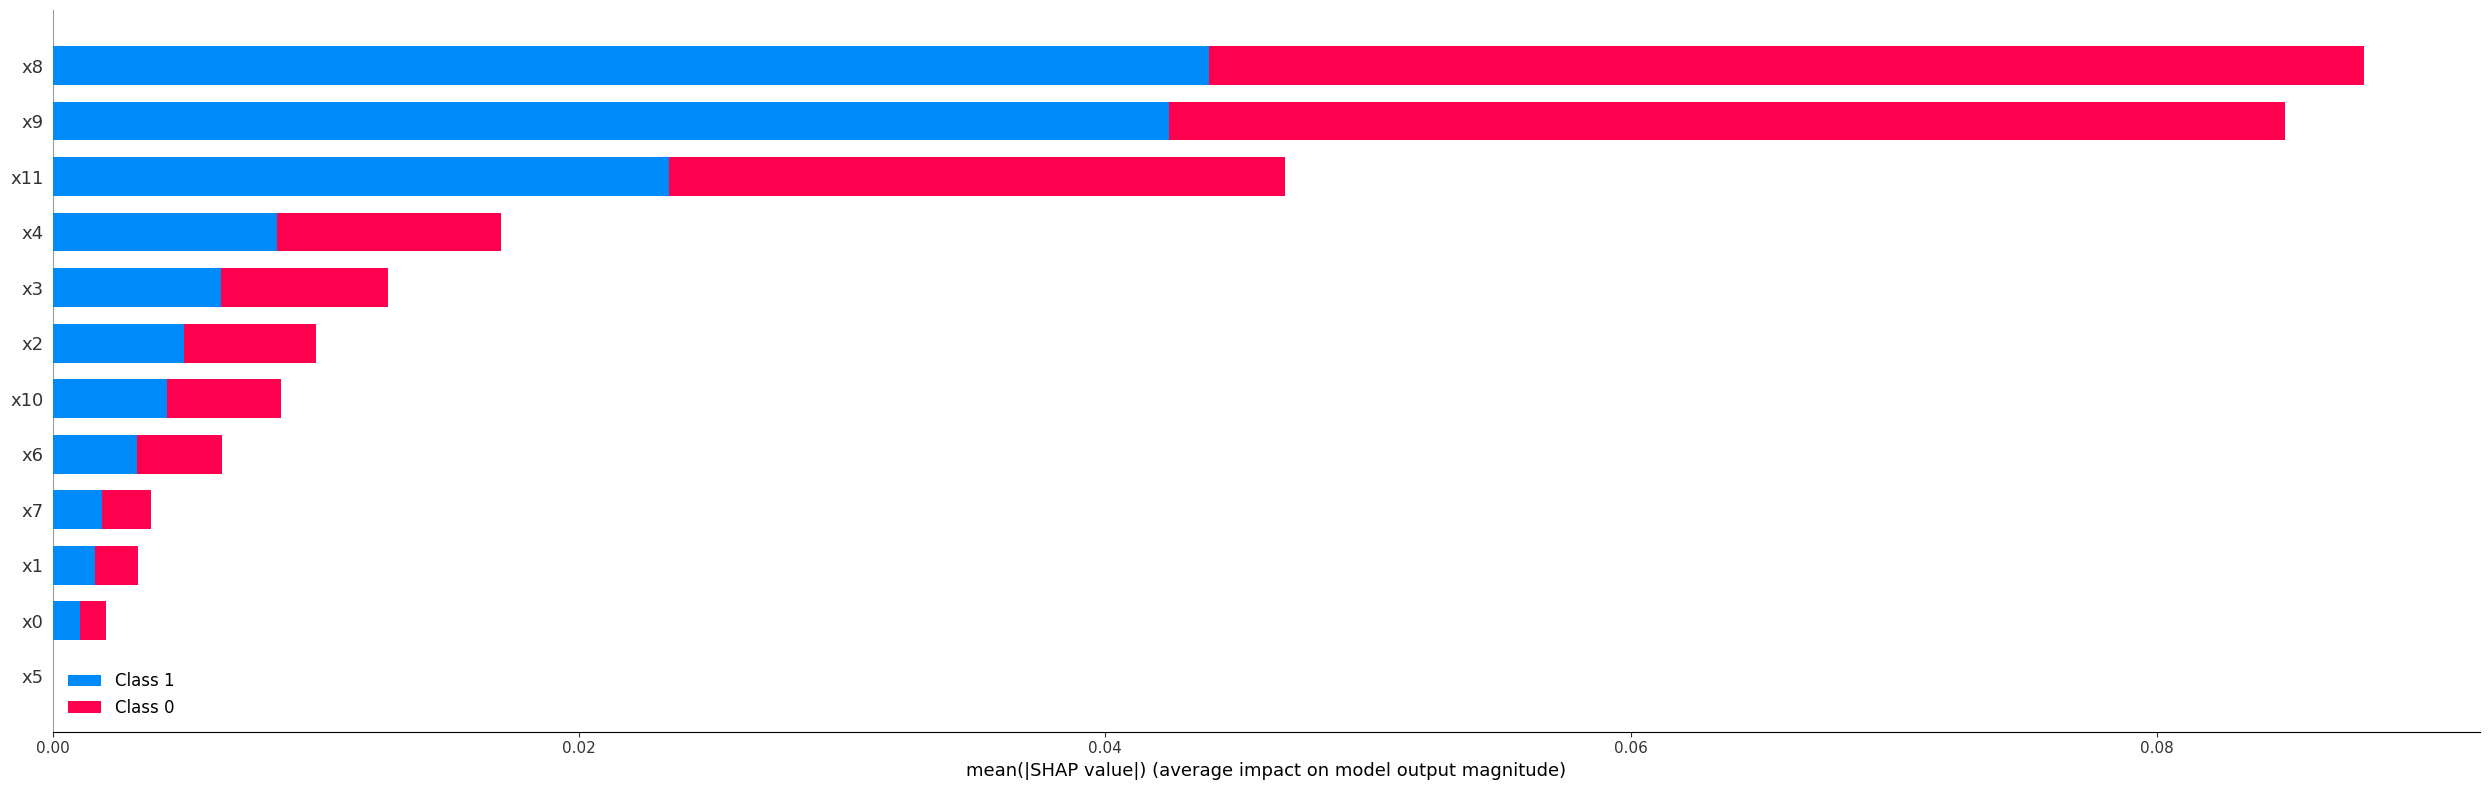

In [26]:
pipelines = 'train_pipeline'; step = 3
args = user_parameters[pipelines][step]['args'][0]

data, config = run(step, args, pipelines, data, config)
data

## Inference workflow: 1. Input assets

In [27]:
pipelines = 'inference_pipeline'; step = 0
args = user_parameters[pipelines][step]['args'][0]

data, config = run(step, args, pipelines, data, config)
data

input asset has already been created at 2023-10-13 01:17:57.236890



============================= ASSET INFO =============================
PIPELINES    : inference_pipeline
ASSETS       : input



==================== current time : 2023-10-13 07:49:46.143456+00:00 (UTC) ====================
************************************************************
************************************************************
>> Load path : ['/home/jovyan/project/ALO_v2/alov2/input/inf/']
>> The file for batch data has been loaded. (File name: /home/jovyan/project/ALO_v2/alov2/input/inf/BF_dup.csv)
>> The file for batch data has been loaded. (File name: /home/jovyan/project/ALO_v2/alov2/input/inf/BF_stats_inf.csv)
==================== Success loading dataframe ====================
>> Drop columns from the input dataframe when set << auto >> mode or specified in the << drop_columns >> in config yaml. (dropped colums:[])


{'dataframe':    Unnamed: 0   No      Time  Ch1  Ch2  Count  Fastening Time  Target Torque  \
 0         498  1.0  18:59:56    1    4  517.0            2578            6.0   
 1         499  1.0  16:31:59    1    4  519.0            2587            6.0   
 2         500  1.0  15:27:55    1    4  492.0            2453            6.0   
 3         498  1.0  18:59:56    1    4  517.0            2578            6.0   
 4         499  1.0  16:31:59    1    4  519.0            2587            6.0   
 5         500  1.0  15:27:55    1    4  492.0            2453            6.0   
 
    Converted Torque  Speed  ...  angle_median    angle_std  torque_max  \
 0              6.04    250  ...        2657.0  1574.932713        6.03   
 1              6.05    250  ...        2669.0  1579.921028        5.98   
 2              6.04    250  ...        2507.0  1520.566223        6.03   
 3              6.04    250  ...        2657.0  1574.932713        6.03   
 4              6.05    250  ...        266

## Inference workflow: 2. Preprocess assets

In [28]:
pipelines = 'inference_pipeline'; step = 1
args = user_parameters[pipelines][step]['args'][0]

data, config = run(step, args, pipelines, data, config)
data

@ local asset_source_code mode: <preprocess> asset exists.



============================= ASSET INFO =============================
PIPELINES    : inference_pipeline
ASSETS       : preprocess



Got model path for saving or loading: 
 /home/jovyan/project/ALO_v2/alov2/.train_artifacts/models/preprocess/
************************************************************
************************************************************
['Count_nan', 'Converted Torque_nan', 'angle_min_nan', 'angle_mean_nan', 'angle_median_nan', 'angle_std_nan', 'angle_max_nan', 'torque_min_nan', 'torque_mean_nan', 'torque_median_nan', 'torque_std_nan', 'torque_max_nan'] 


fatal: No names found, cannot describe anything.


{'dataframe':    Count  Converted Torque  angle_min   angle_mean  angle_median    angle_std  \
 0  517.0              6.04        0.0  2538.899420        2657.0  1574.932713   
 1  519.0              6.05        0.0  2549.233141        2669.0  1579.921028   
 2  492.0              6.04        0.0  2421.243902        2507.0  1520.566223   
 3  517.0              6.04        0.0  2538.899420        2657.0  1574.932713   
 4  519.0              6.05        0.0  2549.233141        2669.0  1579.921028   
 5  492.0              6.04        0.0  2421.243902        2507.0  1520.566223   
 
    angle_max  torque_min  torque_mean  torque_median  ...  angle_min_nan  \
 0     4777.0        0.00     1.114023           0.85  ...            0.0   
 1     4800.0       -0.01     1.107495           0.99  ...            0.0   
 2     4579.0       -0.01     1.411626           1.28  ...            0.0   
 3     4777.0        0.00     1.114023           0.85  ...            0.0   
 4     4800.0       -0.01 

## Inference workflow: 3. TCR assets

In [29]:
pipelines = 'inference_pipeline'; step = 2
args = user_parameters[pipelines][step]['args'][0]

data, config = run(step, args, pipelines, data, config)
data

inference asset has already been created at 2023-10-13 02:42:23.178947



============================= ASSET INFO =============================
PIPELINES    : inference_pipeline
ASSETS       : inference




 ################################### inference_init (sec):  5.5789947509765625e-05 ################################### 

************************************************************
************************************************************
Got model path for saving or loading: 
 /home/jovyan/project/ALO_v2/alov2/.inference_artifacts/models/inference/
Got model path for saving or loading: 
 /home/jovyan/project/ALO_v2/alov2/.train_artifacts/models/train/
Got output path for saving or loading: 
 /home/jovyan/project/ALO_v2/alov2/.inference_artifacts/output/inference/
ignore_columns는 Training 과정에 사용되지 않습니다.
[INFO] XAI 분석 시, 활용할 모델을 로드합니다.
모델을 Load 완료 하였습니다. (모델 위치: /home/jovyan/project/ALO_v2/alov2/.train_artifacts/models/train/best_model_top0.pkl)
################################j

{'dataframe':    Converted Torque  Count  angle_max  angle_min    angle_std   angle_mean  \
 0              6.04  517.0     4777.0        0.0  1574.932713  2538.899420   
 1              6.05  519.0     4800.0        0.0  1579.921028  2549.233141   
 2              6.04  492.0     4579.0        0.0  1520.566223  2421.243902   
 3              6.04  517.0     4777.0        0.0  1574.932713  2538.899420   
 4              6.05  519.0     4800.0        0.0  1579.921028  2549.233141   
 5              6.04  492.0     4579.0        0.0  1520.566223  2421.243902   
 
    angle_median  torque_max  torque_min  torque_std  ...      x4   x5  \
 0        2657.0        6.03        0.00    0.967550  ...  2657.0  0.0   
 1        2669.0        5.98       -0.01    0.931000  ...  2669.0  0.0   
 2        2507.0        6.03       -0.01    0.981037  ...  2507.0  0.0   
 3        2657.0        6.03        0.00    0.967550  ...  2657.0  0.0   
 4        2669.0        5.98       -0.01    0.931000  ...  266